In [1]:
!python --version

Python 3.12.10


In [2]:
# Use Auto3DGM
# Open Anaconda Console via Startmenü
# Starte venv im Ordner des Gits - siehe Anleitung III-3

In [10]:
import pandas as pd
import numpy as np

df = pd.read_csv("data/Combined/results500/landmarks_scaled.csv")

names = df.iloc[:, 0].values
coords = df.iloc[:, 1:].values

# sanity check: must be multiple of 3
if coords.shape[1] % 3 != 0:
    raise ValueError("Number of coordinate columns is not divisible by 3")

# number of landmarks
n_landmarks = coords.shape[1] // 3

# reshape to (N, P, 3)
X = coords.reshape(len(df), n_landmarks, 3)

print("Landmark array shape:", X.shape)

Landmark array shape: (85, 500, 3)


In [11]:
def pairwise_procrustes_distances(X):
    """
    X: (N, P, 3) array of aligned, scaled landmarks
    Returns: (N, N) distance matrix
    """
    N, P, _ = X.shape
    D = np.zeros((N, N), dtype=float)

    for i in range(N):
        diff = X[i][None, :, :] - X          # (N, P, 3)
        D[i] = np.sqrt(np.mean(np.sum(diff**2, axis=2), axis=1))

    return D

#D = pairwise_procrustes_distances(X)

In [13]:
from sklearn.metrics import pairwise_distances

# X is (N, P, 3) -> flatten to (N, P*3)
X_flat = X.reshape(X.shape[0], -1)
#print(X_flat.shape)

# Euclidean distance matrix (same idea as for Zernike/FPFH feature vectors)
D = pairwise_distances(X_flat, metric="euclidean")

(85, 1500)


In [6]:
#D_df = pd.DataFrame(D, index=specimens, columns=specimens)
#D_df.to_csv("pairwise_procrustes_distance_matrix.csv")

#print("Saved pairwise_procrustes_distance_matrix.csv")

In [7]:
S = 1.0 / (1.0 + D)
print(S)

[[1.         0.8761872  0.87772096 ... 0.84976071 0.82481988 0.81893341]
 [0.8761872  1.         0.90614147 ... 0.85304484 0.82896969 0.82295433]
 [0.87772096 0.90614147 1.         ... 0.86111185 0.83399682 0.827212  ]
 ...
 [0.84976071 0.85304484 0.86111185 ... 1.         0.87809608 0.86753255]
 [0.82481988 0.82896969 0.83399682 ... 0.87809608 1.         0.93894856]
 [0.81893341 0.82295433 0.827212   ... 0.86753255 0.93894856 1.        ]]


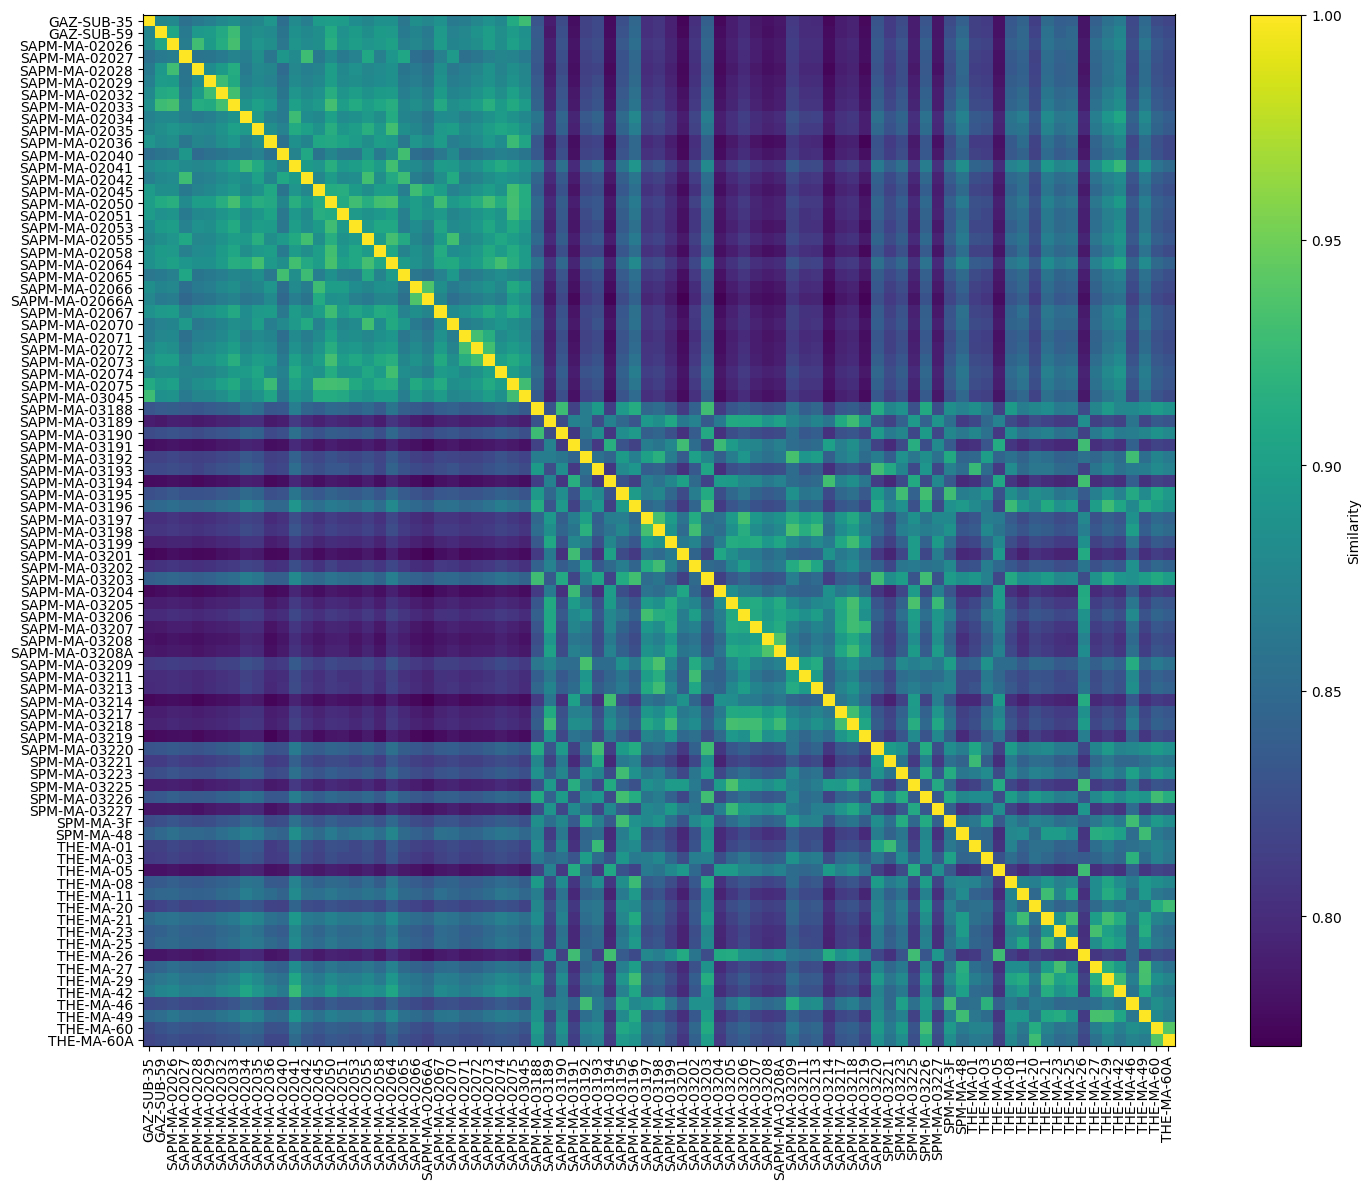

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 12))

im = ax.imshow(S, interpolation="nearest")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Similarity") # (1 / (1 + distance))")

#ax.set_title("Pairwise Similarity of Zernike descriptors")
#ax.set_xlabel("Scan")
#ax.set_ylabel("Scan")

# Tick labels (optional: for many items, this gets crowded)
ax.set_xticks(np.arange(len(names)))
ax.set_yticks(np.arange(len(names)))
ax.set_xticklabels(names, rotation=90)
ax.set_yticklabels(names)

plt.tight_layout()
plt.savefig("pairwise_similarity_auto3dgm-1000.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [16]:
from sklearn.metrics import silhouette_score

labels = np.array([1]*32 + [0]*53)

# D must be symmetric, zeros on diagonal
score = silhouette_score(D, labels, metric="precomputed")
print(score)

0.3248931861571046


In [17]:
# 0.0233782851829215 mit 50
# 0.16885158470553474 mit 100
# 0.2688070184770878 mit 200
# 0.32489318615710294 mit 500   - 
# 0.28727998935980087 mit 1000  - 18 hours

In [22]:
# Save Descriptor for Classification
np.savez(
    "Descriptors/features_Auto3DGM_500.npz",
    X=X_flat,
    y=labels,
    ids=np.array(names, dtype=str)
)
print("Saved")

Saved
